In [ ]:
import os
import sys

if os.path.basename(os.getcwd()) == "testing":
    os.chdir(os.path.dirname(os.getcwd()))
    sys.path.append(os.getcwd())

import unittest
from lossless.util.distribution import (
    weak_colorar_rate,
    discretized_logistic_logp,
    get_mu_and_scale_linear_color
)
import lossless.util.color_transform as color_transform
import torch
import matplotlib.pyplot as plt
import numpy as np

# plt.rcParams["figure.dpi"] = 150

def unget_scale(scale: torch.Tensor) -> torch.Tensor:
    """Helper function to get log_scale from scale

    Args:
        - scale (torch.Tensor): Tensor of shape N x C x H x W
    """
    logscale = torch.log(scale) * -2
    logscale = torch.clamp(logscale, min=-10.0, max=13.8155)
    return logscale

_ = (
# def inflate_mu_and_scale_linear_color(
#     mu: torch.Tensor, log_scale: torch.Tensor, x: torch.Tensor
# ) -> torch.Tensor:
#     """Helper function to get params from mu and scale

#     Args:
#         - mu (torch.Tensor): Tensor of shape N x 3 x H x W
#         - log_scale (torch.Tensor): Tensor of shape N x 3 x H x W
#         - x (torch.Tensor): Tensor of shape N x 3 x H x W
#     """
#     pass


# class TestWeakColorarRate(unittest.TestCase):
#     def simple_case(self):
#         channel_ranges = color_transform.RGBBitdepths()
#         x = torch.tensor([[[[0.40802]], [[0.24332]], [[0.63202]]]])
#         print(x.shape)
#         mu = x + 0.1
#         logscale = torch.tensor([[[[0.0]], [[0.0]], [[0.0]]]])
#         params = inflate_mu_and_scale_linear_color(mu, logscale, x)

# TestWeakColorarRate().simple_case()
)

class MonochromeBitdepths(color_transform.ColorBitdepths):
    def __init__(self) -> None:
        self.bitdepths = [8]
        self.scaling_factors = [255]
        self.bins = [256]
        self.ranges_int = [[0, 255]]


DEFAULT_LOGSCALE = 13.4
DEFAULT_SHIFT = 0.0
DEFAULT_IMG_VALUE = 0.00802


def plot_logp(shifts: np.ndarray | None, logscales: np.ndarray | None):
    channel_ranges = MonochromeBitdepths()
    x = torch.ones((1, 1, 1, 1)) * DEFAULT_IMG_VALUE

    # shifts is a linspace
    logps = []

    if shifts is not None:
        for shift_value in shifts:
            shift = torch.tensor(shift_value)
            mu = x + shift
            log_scale = torch.clamp(
                torch.tensor(DEFAULT_LOGSCALE), min=-10.0, max=13.8155
            )
            scale = torch.exp(-0.5 * log_scale)
            logp = discretized_logistic_logp(mu, scale, x, channel_ranges)
            logps.append(-logp.item())
        plt.plot(shifts, logps)
        plt.xlabel("Shift")
        plt.ylabel("Negative Log Probability")
        plt.title("Negative Log Probability vs Shift")
        plt.show()
    if logscales is not None:
        logps = []
        for logscale_value in logscales:
            shift = torch.tensor(DEFAULT_SHIFT)
            mu = x + shift
            log_scale = torch.clamp(
                torch.tensor(logscale_value), min=-10.0, max=13.8155
            )
            scale = torch.exp(-0.5 * log_scale)
            logp = discretized_logistic_logp(mu, scale, x, channel_ranges)
            logps.append(-logp.item())
        plt.plot(logscales, logps)
        plt.xlabel("Log Scale")
        plt.ylabel("Negative Log Probability")
        plt.title("Negative Log Probability vs Log Scale")
        plt.show()


def logp_image(shifts: np.ndarray, logscales: np.ndarray):
    channel_ranges = MonochromeBitdepths()
    x = torch.ones((1, 1, 1, 1)) * DEFAULT_IMG_VALUE

    logp_matrix = np.zeros((len(logscales), len(shifts)))

    for j, shift_value in enumerate(shifts):
        for i, logscale_value in enumerate(logscales):
            shift = torch.tensor(shift_value)
            mu = x + shift
            log_scale = torch.clamp(
                torch.tensor(logscale_value), min=-10.0, max=13.8155
            )
            scale = torch.exp(-0.5 * log_scale)
            logp = discretized_logistic_logp(mu, scale, x, channel_ranges)
            logp_matrix[i, j] = -logp.item()

    plt.imshow(
        logp_matrix,
        extent=(shifts[0], shifts[-1], logscales[0], logscales[-1]),
        aspect="auto",
        origin="lower",
    )
    plt.colorbar(label="Negative Log Probability")
    plt.xlabel("Shift")
    plt.ylabel("Log Scale")
    plt.title("Negative Log Probability Heatmap")
    plt.show()


logp_image(np.linspace(-0.5, 0.5, 100), np.linspace(-10.0, 13.8154, 100))

tensor(0)


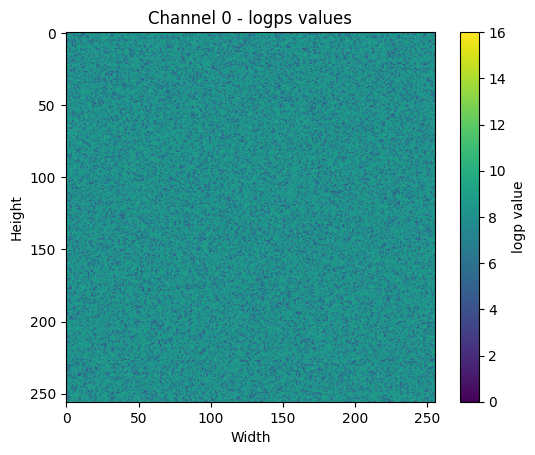

tensor(968)


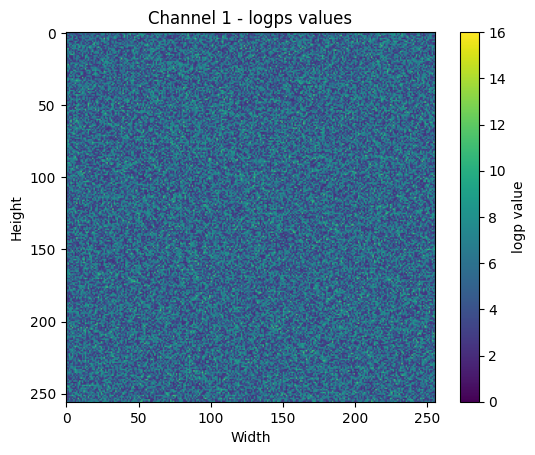

tensor(0)


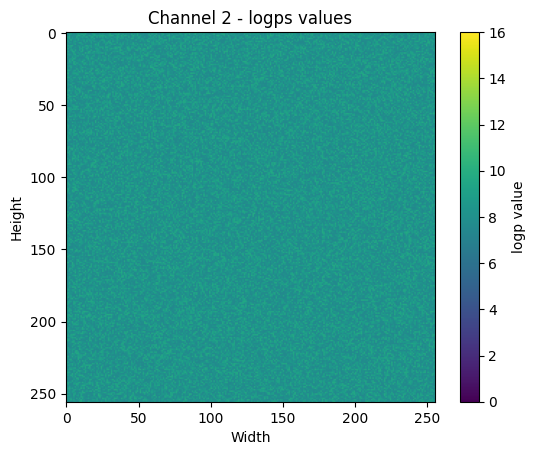

In [5]:
raw_out = torch.tensor(np.load("./testing/data/encoded_raw_out.npy"))
image = torch.tensor(np.load("./testing/data/original_image.npy"))

mu, scale = get_mu_and_scale_linear_color(
    raw_out, image
)

for channel in range(3):
    channel_ranges = MonochromeBitdepths()
    logps = - discretized_logistic_logp(
        mu[:, channel : channel + 1],
        scale[:, channel : channel + 1],
        image[:, channel : channel + 1],
        channel_ranges,
    )
    print((logps >= 10).sum())
    plt.figure()
    plt.title(f"Channel {channel} - logps values")
    plt.imshow(logps[0].permute(1, 2, 0).numpy(), vmin=0, vmax=16)
    plt.colorbar(label="logp value")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.show()